## Step 1. 데이터 구하기

In [19]:
import requests
import os

url = "https://query1.finance.yahoo.com/v7/finance/download/NQ=F?period1=969235200&period2=1603152000&interval=1d&events=history&includeAdjustedClose=true"

# 데이터를 요청하고 그 결과를 response로 받습니다.
response = requests.get(url)

csv_file = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/nasdaq.csv'

# response 의 컨텐츠를 csv로 저장합니다.
with open(csv_file, "w") as fp:  
    fp.write(response.text)

In [20]:
# 저장한 csv를 읽어옵니다.
import pandas as pd
df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994.0
1,2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029.0


In [21]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date            0
Open         1072
High         1072
Low          1072
Close        1072
Adj Close    1072
Volume       1072
dtype: int64

In [22]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 6166
삭제 후 데이터 길이(일자수): 5094


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [24]:
df.loc[df.Low > df.High]

,Date,Open,High,Low,Close,Adj Close,Volume


흠 이상 데이터가 없네요

## Step 2. 기본 통계분석으로 이상치 찾기


### 데이터의 분포를 그려보기


In [26]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


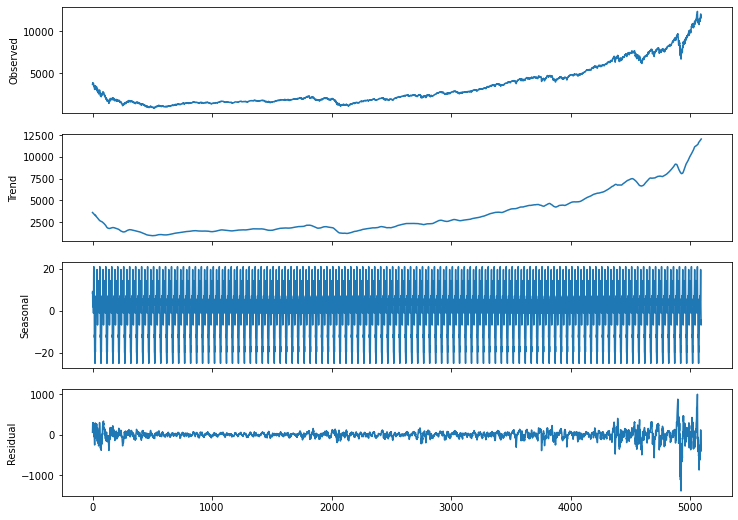

In [28]:
%matplotlib inline
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

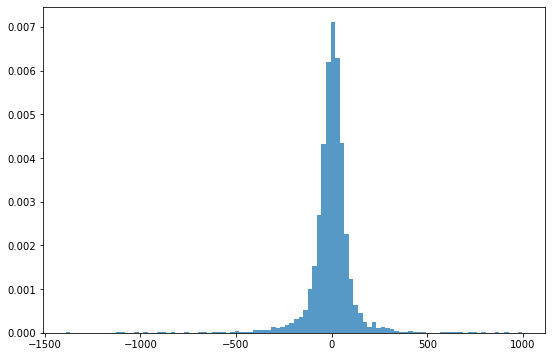

In [29]:
#Residual 분포 그려보기
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [30]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

-0.8942734929026334 0.37117557875830953


p 값이 0.5를 조금 넘었지만 이정도는 괜찮을 것 같습니다

### ## 3σ 기준 신뢰구간으로 이상치 찾기


In [31]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -1.3857940518773666 표준편차: 110.60068205120827
이상치 갯수: 93


In [32]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

66     2000-12-20
73     2001-01-02
91     2001-01-29
92     2001-01-30
136    2001-04-03
          ...    
5083   2020-10-05
5084   2020-10-06
5085   2020-10-07
5086   2020-10-08
5093   2020-10-19
Name: Date, Length: 93, dtype: datetime64[ns]

## Step 3. Unsupervised Clustering 으로 이상치 찾기


### k-means로 분석하기


In [33]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,3324.303285,3355.663089,3290.834806,3326.157530,287799.789978
std,2390.871506,2412.479986,2366.728217,2394.718369,109505.235488
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.251875,1597.572500,1571.058750,1584.191100,220550.460000
50%,2263.775000,2291.211250,2231.463750,2264.287900,268829.760000
75%,4433.603750,4464.010625,4399.788125,4434.981250,319616.697500
max,12064.786259,12214.296509,11897.172140,12066.724264,776809.340000


In [34]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,-1.494218,-1.447168,-1.393323,-1.402187,132.899742
std,113.106458,102.570229,152.449023,110.763008,110724.899203
min,-1280.163546,-1494.231533,-6766.932144,-1389.770659,-603014.586328
25%,-37.912202,-35.100432,-38.148710,-37.371552,-53397.033973
50%,3.575670,3.350366,4.411650,2.958782,-584.124075
75%,40.353926,37.613888,42.843719,40.813609,51481.304420
max,996.821566,933.584382,975.207534,996.232816,810690.898648


In [35]:
sdf.describe()

,Open,High,Low,Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,-0.008616,-0.006603,-0.013197,-0.009202,22.286330
std,11.597437,10.750511,13.684042,11.536247,14557.355693
min,-25.636086,-26.520436,-46.655356,-25.083118,-35905.398752
25%,-6.213432,-6.863078,-8.514140,-6.951926,-11576.678563
50%,2.283903,2.699136,3.168488,2.210146,-513.736640
75%,6.669267,6.280691,8.667607,6.577663,10226.500457
max,22.521422,20.130833,17.316765,20.989196,34534.955255


In [36]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.49421837  -1.44716848  -1.39332267  -1.40218679 132.89974227]


array([[ 0.94173218,  0.84218124,  0.61539545,  0.59799575,  0.083212  ],
       [ 0.48655464,  1.27770882,  1.05172017,  2.08212326,  0.10453018],
       [ 1.89305329,  2.00817542,  1.55570566,  2.72037058, -0.08887086],
       ...,
       [-0.65531897, -1.82608069, -0.75113879, -1.32833825,  0.28433475],
       [-1.31334711, -1.62375976, -0.5501619 , -2.17905108, -0.36419423],
       [-2.12456827, -2.48917183, -1.98753474, -3.70655626, -0.28328824]])

## 1. K-mean

In [37]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.

[0 0 0 ... 1 1 1]


In [38]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

[0 1]
[4278  816]


In [39]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]
\

['group:0-count:1078',
 'group:1-count:100',
 'group:2-count:1',
 'group:3-count:107',
 'group:4-count:13',
 'group:5-count:224',
 'group:6-count:409',
 'group:7-count:32',
 'group:8-count:1066',
 'group:9-count:300',
 'group:10-count:682',
 'group:11-count:544',
 'group:12-count:68',
 'group:13-count:20',
 'group:14-count:450']

### ✔️1. 어떤 날들이 분류된건지 (원본 코스피 데이터에서 탐색)

In [42]:
# 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df[(kmeans.labels_==2)]

,Date,Open,High,Low,Close,Adj Close,Volume
4961,2020-05-06,8928.5,9056.5,1903.0,8952.0,8952.0,414045.0


In [43]:
df[(kmeans.labels_==4)]

,Date,Open,High,Low,Close,Adj Close,Volume
4917,2020-03-13,7100.000000,7978.000000,6942.500000,7915.750000,7915.750000,584274.0
4918,2020-03-15,7100.000000,7978.000000,6942.500000,7215.250000,7215.250000,578813.0
4919,2020-03-16,7903.000000,7905.250000,6927.000000,7057.500000,7057.500000,307368.0
4920,2020-03-17,7053.000000,7552.250000,6948.750000,7405.250000,7405.250000,317501.0
4921,2020-03-18,7386.000000,7392.250000,6830.000000,7225.250000,7225.250000,156283.0
4922,2020-03-19,7251.750000,7521.500000,6894.250000,7293.500000,7293.500000,115519.0
4923,2020-03-20,7195.000000,7649.000000,7153.500000,7417.979980,7417.979980,562616.0
4924,2020-03-22,6798.000000,6798.000000,6628.750000,6688.750000,6688.750000,321230.0
4925,2020-03-23,6798.000000,7316.250000,6628.750000,6984.500000,6984.500000,633237.0
4926,2020-03-24,7005.750000,7572.250000,7005.750000,7554.750000,7554.750000,556553.0


In [45]:
# 2020-05-06 주변 정황
df.iloc[4957:4965]

,Date,Open,High,Low,Close,Adj Close,Volume
4957,2020-05-01,8847.00,8879.00,8672.00,8718.00,8718.00,414560.0
4958,2020-05-03,8624.00,8642.25,8562.00,8579.50,8579.50,955357.0
4959,2020-05-04,8624.00,8828.00,8556.25,8795.50,8795.50,381914.0
4960,2020-05-05,8806.25,9020.00,8798.50,8924.25,8924.25,367233.0
4961,2020-05-06,8928.50,9056.50,1903.00,8952.00,8952.00,414045.0
4962,2020-05-07,8947.50,9126.00,8930.25,9107.75,9107.75,383884.0
4963,2020-05-08,9115.00,9238.00,9103.25,9218.25,9218.25,362315.0
4964,2020-05-10,9194.75,9257.25,9174.75,9249.00,9249.00,673663.0


### ✔️2. 각 그룹은 어떤 특징을 갖고 있는지

In [48]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인해보겠습니다.
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,0.200505,0.201368,0.195809,0.239635,-0.415852
1,-2.105660,-2.130475,-1.551833,-2.044875,-0.262899
2,-0.370669,-0.377400,-44.383381,-0.482650,-0.622880
3,2.336942,2.414856,1.916636,2.372959,-0.223189
4,-8.262590,-7.541295,-6.406347,-7.407110,-1.791962
5,0.100704,0.056806,-0.220629,-0.270130,1.979857
6,0.911994,0.940576,0.796475,0.987251,-0.532713
7,-4.254156,-4.574573,-3.233543,-4.260124,0.491289
8,-0.131210,-0.118335,-0.097377,-0.119356,0.376102
9,0.112725,0.107841,0.145244,0.168976,-1.904008


### ✔️3. 왜 이상치로 분류된걸까?

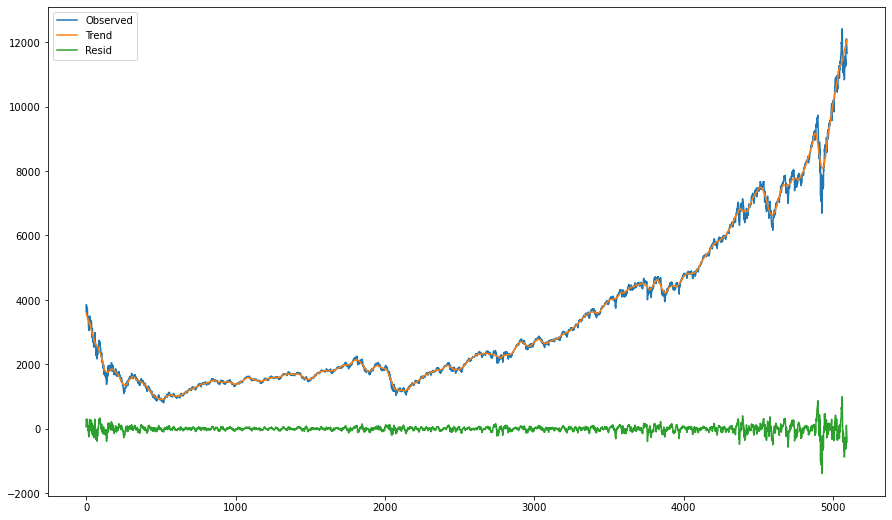

In [47]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax,label='Resid', legend=True)
plt.show()

예상치보다 많이 올라서 이상치로 분류된 것 같습니다.
부럽네요.

## 2. DBSCAN

In [49]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [50]:
# 분류된 라벨들은 이렇게 확인할 수 있어요
print(clustering.labels_)

[ 0  0  0 ...  0 -1 26]


In [51]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:194',
 'group:0-count:4832',
 'group:1-count:3',
 'group:2-count:13',
 'group:3-count:2',
 'group:4-count:2',
 'group:5-count:3',
 'group:6-count:2',
 'group:7-count:3',
 'group:8-count:2',
 'group:9-count:2',
 'group:10-count:2',
 'group:11-count:2',
 'group:12-count:2',
 'group:13-count:2',
 'group:14-count:2',
 'group:15-count:2',
 'group:16-count:2',
 'group:17-count:2',
 'group:18-count:2',
 'group:19-count:2',
 'group:20-count:2',
 'group:21-count:2',
 'group:22-count:2',
 'group:23-count:4',
 'group:24-count:2',
 'group:25-count:2',
 'group:26-count:2']

## Step 4. LSTM 오토인코더로 이상치 찾기


In [52]:
# 필요한 라이브러리를 불러옵니다

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [53]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

### 데이터 전처리

In [54]:
from sklearn.preprocessing import StandardScaler

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [55]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


### 모델 만들기

In [56]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [57]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [58]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
159/159 [==============================] - ETA: 0s - loss: 1.2412 - mae: 1.2412
Epoch 00001: val_loss improved from inf to 0.71230, saving model to /home/aiffel0048/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 5s 29ms/step - loss: 1.2412 - mae: 1.2412 - val_loss: 0.7123 - val_mae: 0.7123
Epoch 2/50
158/159 [============================>.] - ETA: 0s - loss: 0.4879 - mae: 0.4879
Epoch 00002: val_loss improved from 0.71230 to 0.68657, saving model to /home/aiffel0048/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 4s 27ms/step - loss: 0.4881 - mae: 0.4881 - val_loss: 0.6866 - val_mae: 0.6866
Epoch 3/50
159/159 [==============================] - ETA: 0s - loss: 0.4092 - mae: 0.4092
Epoch 00003: val_loss improved from 0.68657 to 0.52488, saving model to /home/aiffel0048/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 4s 28ms/step - loss: 0.4092 - mae: 0.4092 - v

In [59]:
model.load_weights(checkpoint_path)

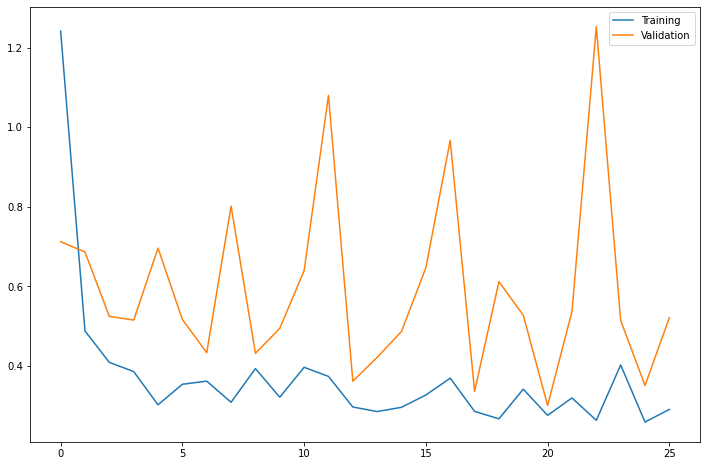

In [60]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

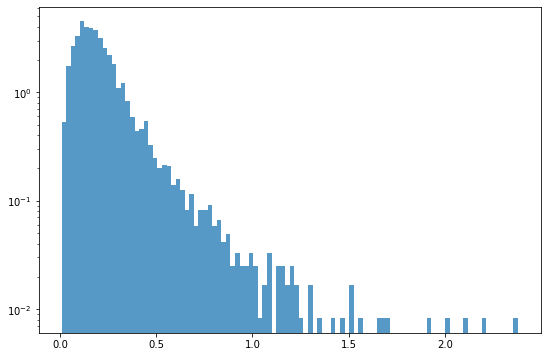

In [61]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [62]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 3
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss


In [63]:
threshold = 0.3
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
13,2000-10-19,3180.000000,3447.000000,3180.000000,3447.000000,3447.000000,65554.0,0.347433
14,2000-10-20,3437.000000,3555.500000,3412.000000,3499.500000,3499.500000,50436.0,0.556745
15,2000-10-23,3498.500000,3563.500000,3406.000000,3471.000000,3471.000000,65144.0,0.521835
16,2000-10-24,3477.000000,3535.000000,3329.000000,3342.500000,3342.500000,64818.0,0.425436
23,2000-11-02,3263.500000,3361.500000,3229.500000,3316.500000,3316.500000,57125.0,0.310718
...,...,...,...,...,...,...,...,...
5076,2020-10-08,11473.200195,11578.799805,11469.799805,11539.000000,11539.000000,403379.0,0.448241
5077,2020-10-09,11562.000000,11739.000000,11552.500000,11724.799805,11724.799805,408445.0,0.459696
5078,2020-10-12,11722.799805,12197.000000,11687.799805,12098.200195,12098.200195,756438.0,0.784046
5079,2020-10-13,12100.000000,12249.000000,12019.000000,12094.000000,12094.000000,754735.0,0.858219


/home/aiffel0048/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


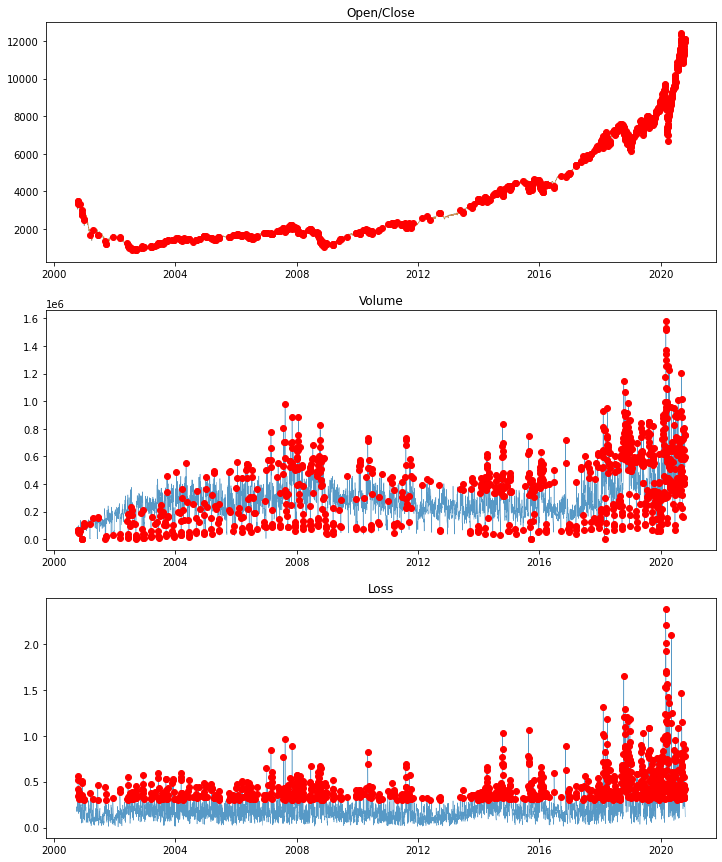

In [64]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])